In [1]:
%pylab inline
import pandas as pd
import scipy.io.wavfile as wavefile
import scipy.signal
import soundfile
import io
import hashlib
import librosa

Populating the interactive namespace from numpy and matplotlib


In [2]:
def normalize_wav(arr,trunc=False, always_norm=False):
    if trunc and len(arr)>16000:
        arr=arr[:16000]
    arr=arr-np.mean(arr)
    if len(arr)<16000:
        m=(16000-len(arr))
        arr=np.concatenate([np.zeros([int(m/2)]), arr, np.zeros(m-int(m/2))])
    assert len(arr)==16000
    max_v=np.max(np.abs(arr))+1e-8
    if max_v>1 or always_norm: 
        arr=arr/max_v
    return arr.astype(np.float32)
def read_file(fname,trunc=False):
    arr=wavefile.read(fname)[1].astype(np.float32)
    return normalize_wav(arr,trunc=trunc)
def read_info(infofile):
    traininfo=pd.read_csv(infofile)
    print traininfo.shape 
    traininfo=traininfo.groupby("sha256").first().reset_index()
    print traininfo.shape
    traininfo=traininfo[traininfo['clear']==1]
    print traininfo.shape
    display(traininfo['label'].value_counts().to_frame().T)
    return traininfo

In [3]:
traininfo=read_info("../info/train_info.csv")
testinfo=read_info("../info/test_info.csv")

(64721, 11)
(64300, 11)
(64133, 11)


unknown    no  stop   yes    on  down    go  right  left   off    up
label    40747  2354  2354  2349  2343  2343  2339   2338  2331  2325  2310

(153312, 11)
(153312, 11)
(138579, 11)


Empty DataFrame
Columns: []
Index: [label]

In [4]:
traininfo.head()

sha256    label  \
0  000066f4dd45cff5cf15f2364795988fc8cfd28bf0347b...  unknown   
1  0000a8a532b53b630c163e344c74c568e1f187babb87ea...  unknown   
2  00025f449b61c01ff680d038bbff5cbc3e0b479171ffc3...     stop   
3  000303f8c9739bfa452471a56473d3fd76c5941ae485a0...      yes   
4  00031ab8987fd03890b22b05f8c3b1e741c1e6d421a64f...     down   

                                     path  target   subject  subject_id  \
0  train/audio/tree/1ba20be2_nohash_0.wav       9  1ba20be2        1105   
1  train/audio/four/e5d2e09d_nohash_0.wav       9  e5d2e09d         866   
2  train/audio/stop/e5d2e09d_nohash_0.wav       8  e5d2e09d         866   
3   train/audio/yes/712e4d58_nohash_4.wav      11  712e4d58         918   
4  train/audio/down/f5733968_nohash_3.wav       0  f5733968        1648   

      id  fold  compress_ratio  compress_ratio2  clear  
0  41019     5        3.003567         8.908686      1  
1  24780     6        2.257655         9.908655      1  
2  10419     6        2.212389         9.360831      1  
3    172     8        3.916769        21.304927      1  
4  51515     8        3.017160        19.347037      1

In [5]:
testinfo.head()

sha256  label  \
2  000145ee640107576eb5e55f13b83aa1d3377264a85019...    NaN   
3  0001a077372dcbbf4247d3df4da43de2051c4a6cb52064...    NaN   
4  000211515d30b992480dbc31e77b4459e0c317eac51c60...    NaN   
5  000224891146902753b89988598d054e8581a2aa4d82cb...    NaN   
6  0002ac45fcb34ce90a428ddc78853bad59f61a08bfc5a5...    NaN   

                            path  target  subject  subject_id      id  fold  \
2  test/audio/clip_d025985eb.wav     NaN      NaN         NaN  141339     8   
3  test/audio/clip_cf9ecec71.wav     NaN      NaN         NaN  159286     6   
4  test/audio/clip_a6fc03916.wav     NaN      NaN         NaN  174977     6   
5  test/audio/clip_ec13e45ce.wav     NaN      NaN         NaN  113714     4   
6  test/audio/clip_924a561db.wav     NaN      NaN         NaN  255866     9   

   compress_ratio  compress_ratio2  clear  
2             NaN        22.145329      1  
3             NaN        23.477623      1  
4             NaN        11.951447      1  
5             NaN         7.909046      1  
6             NaN        14.134276      1

In [6]:
import os
class NoiseGenerator(object):
    def __init__(self,noise_path="../input/train/audio/_background_noise_/",silence_ratio=0.01):
        filenames = [u for u in os.listdir(noise_path) if u.endswith('.wav')]
        assert (len(filenames)>0)
        print "loaded {} noise files".format(len(filenames))
        self.data={u:soundfile.read(noise_path+"/"+u)[0] for u in filenames}
        self.filenames=filenames
    def generate_single(self,always_norm):
        i=random.choice(self.filenames,1)[0]
        x=self.data[i]
        j=int(np.random.random()*(len(x)-2000))
        return normalize_wav(x[j:j+16000],always_norm=always_norm)
    def generate(self,always_norm=False):
        rnd=np.random.random()
        if rnd<0.2:
            noise= self.generate_single(always_norm)
        elif rnd<0.8:
            a,b=self.generate_single(always_norm),self.generate_single(always_norm)
            p=np.random.random()
            noise=p*a+(1-p)*b
        else:
            a,b,c=self.generate_single(always_norm),self.generate_single(always_norm),self.generate_single(always_norm)
            p=np.random.random(3)
            p=np.exp(p)
            p=p/np.sum(p)
            noise=a*p[0]+b*p[1]+c*p[2]
        noise=normalize_wav(noise,always_norm=always_norm)
        rnd=np.random.random()
        if rnd>0.66:
            noise[:int(np.random.random()*len(noise))]=0
        elif rnd<0.33:
            noise[int(np.random.random()*len(noise)):]=0
        return noise.astype(np.float32)
        

In [7]:
if 0:
    for k,u in a.data.items():
        print k
        plt.plot(u[:1000]);plt.show()
if 0:
    a=NoiseGenerator()
    for i in range(10):
        plt.plot(a.generate());plt.show()    

In [8]:
datainfo=pd.concat([traininfo,testinfo]).reset_index(drop=True)
datainfo.head()

sha256    label  \
0  000066f4dd45cff5cf15f2364795988fc8cfd28bf0347b...  unknown   
1  0000a8a532b53b630c163e344c74c568e1f187babb87ea...  unknown   
2  00025f449b61c01ff680d038bbff5cbc3e0b479171ffc3...     stop   
3  000303f8c9739bfa452471a56473d3fd76c5941ae485a0...      yes   
4  00031ab8987fd03890b22b05f8c3b1e741c1e6d421a64f...     down   

                                     path  target   subject  subject_id  \
0  train/audio/tree/1ba20be2_nohash_0.wav     9.0  1ba20be2      1105.0   
1  train/audio/four/e5d2e09d_nohash_0.wav     9.0  e5d2e09d       866.0   
2  train/audio/stop/e5d2e09d_nohash_0.wav     8.0  e5d2e09d       866.0   
3   train/audio/yes/712e4d58_nohash_4.wav    11.0  712e4d58       918.0   
4  train/audio/down/f5733968_nohash_3.wav     0.0  f5733968      1648.0   

      id  fold  compress_ratio  compress_ratio2  clear  
0  41019     5        3.003567         8.908686      1  
1  24780     6        2.257655         9.908655      1  
2  10419     6        2.212389         9.360831      1  
3    172     8        3.916769        21.304927      1  
4  51515     8        3.017160        19.347037      1

In [9]:
from multiprocessing import pool
import keras
class DataSet(object):
    def __init__(self,datainfo,batch_size=128,name=None):
        self.batch_size=batch_size
        #self.datainfo=datainfo
        self.files=[str(u) for u in datainfo['path']]
        self.N=datainfo.shape[0]
        self._noisor=None
        self._data=None
        
        self.max_background_volume=0.1 #How loud the background noise should be, between 0 and 1.
        self.background_frequency=0.8  #How many of the training samples have background noise mixed in.
        self.noise_threshold=0.8/12
        self.time_shift_ms=100 #Range to randomly shift the training audio by in time.
        self.time_shift_samples= self.time_shift_ms/1000.0*16000
    
    @property
    def n_epoch(self):
        return self.N//self.batch_size
    @property
    def noisor(self):
        if self._noisor is None:
            self._noisor=NoiseGenerator()
        return self._noisor
    @property
    def data(self):
        if self._data is None:
            files=self.files
            p=pool.Pool(8)
            values=p.map(read_file ,["../input/"+u for u in files])
            #label_index=[self.labels[u] for u in files]
            self._data= dict(zip(files,values))
            p.close()
            p.join()
            print "loaded {} wave files".format(len(files))
        return self._data
    def __next__(self):
        return self.next()
    def generate(self,noise):
        filename=np.random.choice(self.files,1)[0]
        arr=self.data[filename]
        time_shift=int(self.time_shift_samples*(2*np.random.random()-1))
        if time_shift>0:
            arr=np.concatenate([np.zeros(time_shift),arr[time_shift:]])
        elif time_shift<0:
            arr=np.concatenate([arr[:time_shift],np.zeros(-time_shift)])
        if np.random.random()<self.background_frequency:
            noise_ratio=np.random.random()*self.max_background_volume
            arr+=noise*noise_ratio
        if np.random.random()<0.5:
            arr=normalize_wav(arr,always_norm=True)
            scale=np.random.random()/2.0+0.4
            arr=scale*arr
        else:
            arr=normalize_wav(arr,always_norm=False)
        return (0,arr.astype(np.float32))
    def next(self):
        r=np.random.random()
        if r<self.noise_threshold:
            if np.random.random()>0.7:
                noise=self.noisor.generate(always_norm=True)
            else:
                noise=self.noisor.generate(always_norm=False)                
            return (0,noise)
        else:
            noise=self.noisor.generate(always_norm=True)
            return self.generate(noise)
    
class DataGenerator(object):
    def __init__(self,datainfo,batch_size=32):
        self.batch_size=batch_size
        self.traininfo=datainfo
        self.trainset=DataSet(self.traininfo,name='train',batch_size=self.batch_size)
    def next_train(self):
        while 1:
            lst=[self.trainset.next() for _ in range(self.batch_size)]
            labels,values=zip(*lst)
            labels=np.zeros([len(labels),20,64, 224, 1],dtype=np.float32)
            values=np.array(values).astype(np.float32)
            yield values,labels

Using TensorFlow backend.


In [10]:
if 0:
    a=DataGenerator(datainfo)
    lst=[]
    for i in range(120):
        lst.append(a.trainset.next()[0])
    display(pd.Series(lst).value_counts().sort_index().to_frame().T)

In [11]:
datagen=DataGenerator(datainfo,batch_size=16)

In [12]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization, Lambda
from keras.layers import Conv2D,Conv1D,MaxPooling2D,GlobalMaxPooling1D, Flatten, CuDNNLSTM
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [13]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [14]:
import scipy.io
def get_morse_W(K,ga,be,method='bandwidth' ):
    filename='../morse_g{:.2f}_b{:.2f}_{}.mat'.format(ga,be,method)
    W=scipy.io.loadmat(filename)['W']
    assert(K<5)
    W=W[:,:,K]
    print filename,W.shape,W.dtype,np.sum(W)
    return W 

In [15]:
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
class WaveletLayer(Layer):

    def __init__(self, window_size=800,  **kwargs):
        W=get_morse_W(0,ga=3,be=1)
        self.IMAGE_WIDTH=224
        self.W=tf.constant(W,dtype=tf.complex64)
        self.window_size=window_size
        self.stride=window_size/2
        self.n_freq=self.W.shape[1]
        super(WaveletLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(WaveletLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call_one(self,x):
        x=tf.cast(x,tf.complex64)
        X=tf.fft(x)
        XW= tf.reshape(X,[-1,1])*self.W
        XW=tf.transpose(XW)
        img=tf.map_fn(lambda u: tf.abs(tf.ifft(u)),XW,dtype=tf.float32);
        img=tf.log1p(img)
        img=img/(K.max(img)+1e-7)
        img=img*tf.cast(img>0.1,dtype=tf.float32)
        range20=tf.constant(range(20),dtype=tf.float32)
        images=tf.map_fn(lambda u: tf.image.resize_images(tf.expand_dims(tf.random_crop(img,[51,800]),-1),
                                                            [64,self.IMAGE_WIDTH]),range20)
        return images
    def call(self, X):
        imgs=K.map_fn(self.call_one, X)
        return imgs

    def compute_output_shape(self, input_shape):
        return (None,20, 64, self.IMAGE_WIDTH, 1) 
    def get_config(self):
        config = {
            'window_size': self.window_size,
        }
        base_config = super(WaveletLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    

In [16]:
def f(b):
    b=np.squeeze(b)
    plt.figure(figsize=(10,16))
    for i,bb in enumerate(b):
        bb=255*bb
        bb[bb>255]=255
        bb=bb.astype(np.uint8)
        subplt=plt.subplot(10,4,i+1)
        imshow(bb,aspect='auto',cmap='gray',vmax=255)#;plt.show()
        subplt.axis('off')
    plt.show()
if 0:
    x1=soundfile.read("../input/train/audio/no/0132a06d_nohash_0.wav")[0]
    x2=soundfile.read("../input/train/audio/yes/0132a06d_nohash_0.wav")[0]
    with tf.Session() as sess:
        layer=WaveletLayer(W310)
        a=tf.placeholder('float32',[None, 16000])
        %time op=layer.call(a)
        xx=np.array([x1,x2, np.zeros_like(x1)])
        b=sess.run(op,feed_dict={a:xx})
        print b.shape,np.isnan(b).sum()
        for arr in b[:1]:
            f(arr)


In [17]:
from keras.layers import UpSampling2D
def conv_layers(x,  dropout=0.5):
    #[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    #1
    for _ in range(2):
        x = Conv2D(64, kernel_size=(3,3), padding='same')(x)
        x=(Activation("relu"))(x)
    
    x=(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='same'))(x)
    
    #2
    for _ in range(2):    
        x = Conv2D(64, kernel_size=(3,3), padding='same' )(x)
        x=(Activation("relu"))(x)
    x=(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='same'))(x)

    #3
    for _ in range(3):    
        x = Conv2D(32, kernel_size=(3,3), padding='same' )(x)
        x=(Activation("relu"))(x)
    x=(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='same'))(x)
    
    #4
    for _ in range(3):    
        x = Conv2D(32, kernel_size=(3,3), padding='same' )(x)
        x=(Activation("relu"))(x)
    x=(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='same'))(x)


    print x.shape
    x=Lambda(lambda u: u, name="encoder_output")(x)
    #x=(Flatten())(x)
    
    return x

def unconv_layers(x,  dropout=0.5):
    #[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

    #4
    for _ in range(3):
        x = Conv2D(32, kernel_size=(3,3), padding='same' )(x)
        x=(Activation("relu"))(x)
    x=(UpSampling2D(size=(2, 2) ))(x)
    
    #3
    for _ in range(3):    
        x = Conv2D(32, kernel_size=(3,3), padding='same' )(x)
        x=(Activation("relu"))(x)
    x=(UpSampling2D(size=(2, 2) ))(x)
    #2
    for _ in range(2):    
        x = Conv2D(64, kernel_size=(3,3), padding='same' )(x)
        x=(Activation("relu"))(x)
    x=(UpSampling2D(size=(2, 2) ))(x)

    #1
    for _ in range(2):    
        x = Conv2D(64, kernel_size=(3,3), padding='same' )(x)
        x=(Activation("relu"))(x)
    x=(UpSampling2D(size=(2, 2) ))(x)
    print x.shape
    return x

def make_tf_cnv_model(input_shape = (16000,), output_num=12,dropout=0.5):
    if 1:
        input_x = keras.layers.Input(shape=input_shape,name='wav_input')
        x = WaveletLayer(name='encoder_input')(input_x)
        print "spect output shape",x.shape        
        encoder_input_x=keras.layers.Lambda(lambda u: tf.reshape(u,[-1,64, 224, 1]))(x)
        print "encoder input shape",encoder_input_x.shape        
        encoder_x= conv_layers(encoder_input_x )
        print "encoder output shape",encoder_x.shape
        decoder_x=unconv_layers(encoder_x)
        print "decoder output shape",decoder_x.shape
        outputs= (Dense(1,activation='sigmoid'))(decoder_x)
        if 0:
            outputs=keras.layers.Lambda(lambda u: tf.exp(3*u[0])*(u[0]-u[1])**2)([encoder_input_x,outputs])
            outputs=Lambda(lambda u: tf.reshape(u,[-1,20, 64, 224, 1]))(outputs)
        else:
            outputs=keras.layers.Lambda(lambda u: -u[0]*tf.log(u[1]+1e-7) + (u[0]-u[1])**2 )([encoder_input_x,outputs])
            outputs=Lambda(lambda u: tf.reshape(u,[-1,20, 64, 224, 1]))(outputs)
        print "outputs shape",outputs.shape
        model=keras.Model(inputs=input_x,outputs=outputs)
        return model

In [18]:
backend.clear_session()
model=make_tf_cnv_model(dropout=0.2)

../morse_g3.00_b1.00_bandwidth.mat (16000, 51) float64 76320.7147149
spect output shape (?, 20, 64, 224, 1)
encoder input shape (?, 64, 224, 1)
(?, 4, 14, 32)
encoder output shape (?, 4, 14, 32)
(?, 64, 224, 64)
decoder output shape (?, 64, 224, 64)
outputs shape (?, 20, 64, 224, 1)


In [19]:
model.count_params()

360961

In [20]:
#SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [21]:
#model.summary()

In [22]:
def ENCODER_LOSS(y_true,y_pred):
    return K.mean(y_pred)
    #return K.mean(y_pred**2)

In [23]:
model.compile(loss=ENCODER_LOSS, optimizer='adam',metrics=[])

In [24]:
checkpoint = keras.callbacks.ModelCheckpoint("tf_cov2d_encoder_v1.h5", monitor='loss', 
                                             verbose=0, 
                                             save_best_only=True, 
                                             save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='loss', patience=2)

In [ ]:
model.fit_generator(generator=datagen.next_train(),
                        steps_per_epoch=datagen.trainset.n_epoch  ,
                        epochs=200,
                        validation_data=None,
                        validation_steps=None,
                        callbacks=[checkpoint, early_stopping] 
                   )

Epoch 1/200
loaded 6 noise files
loaded 202712 wave files
12669/12669 [==============================] - 17029s 1s/step - loss: 0.0298
Epoch 2/200
12669/12669 [==============================] - 16259s 1s/step - loss: 0.0291
Epoch 3/200
12669/12669 [==============================] - 16190s 1s/step - loss: 0.0285
Epoch 4/200
12669/12669 [==============================] - 16140s 1s/step - loss: 0.0281
Epoch 6/200
12669/12669 [==============================] - 16164s 1s/step - loss: 0.0279
Epoch 7/200
12669/12669 [==============================] - 16126s 1s/step - loss: 0.0279
Epoch 8/200
12669/12669 [==============================] - 16142s 1s/step - loss: 0.0279
Epoch 9/200
 4829/12669 [==========>...................] - ETA: 2:46:36 - loss: 0.0278

In [40]:
a=keras.models.load_model("tf_cov2d_encoder_v1.h5",custom_objects={'WaveletLayer':WaveletLayer,'tf':tf,'ENCODER_LOSS':ENCODER_LOSS})

../morse_g3.00_b1.00_bandwidth.mat (16000, 51) float64 76320.7147149


In [28]:
encoder_input=[u for u in model.layers if u.name=='encoder_input'][0]
#encoder_output=[u for u in model.layers if u.name=='encoder_output'][0]
decoder_output=Lambda(lambda u:  tf.reshape(u,[-1,20, 64, 224, 1]))(model.layers[-3].output)

In [328]:
#m=keras.models.load_model("tf_cov2d_encoder_v1.h5", custom_objects={'WaveletLayer':WaveletLayer,'tf':tf,'ENCODER_LOSS':ENCODER_LOSS})

In [29]:
def f(b):
    b=np.squeeze(b)
    plt.figure(figsize=(10,16))
    for i,bb in enumerate(b):
        bb=255*bb
        bb[bb>255]=255
        bb=bb.astype(np.uint8)
        subplt=plt.subplot(10,4,i+1)
        imshow(bb,aspect='auto',cmap='gray',vmax=255)#;plt.show()
        subplt.axis('off')
    plt.show()
if 1:
    x1=soundfile.read("../input/train/audio/no/0132a06d_nohash_0.wav")[0]
    x2=soundfile.read("../input/train/audio/house/016e2c6d_nohash_0.wav")[0]
    sess= K.get_session()
    layer=WaveletLayer()
    xx=np.array([x1,x2])
    ops=[encoder_input.output,decoder_output]        
    keras_fun= K.function([model.layers[0].input],ops)
    o1,o3=keras_fun([xx])
#         intermediate_layer_model = keras.Model(inputs=model.input,
#                                          outputs=ops)
#         o1,o2,o3 = intermediate_layer_model.predict(xx)
        

../morse_g3.00_b1.00_bandwidth.mat (16000, 51) float64 76320.7147149


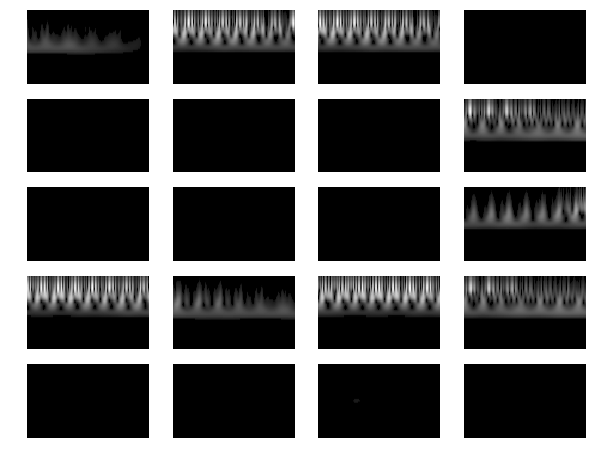

In [30]:
f(o1[0])

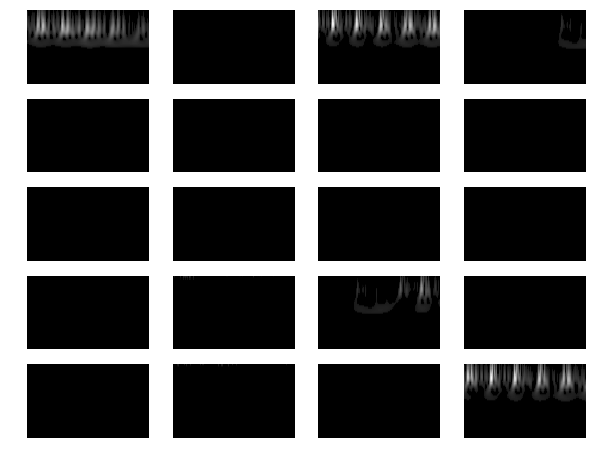

In [31]:
f(o1[1])

In [32]:
abs(o3[0]+o1[0]).sum()

54933.77

In [33]:
o3.min()

3.2971591e-16

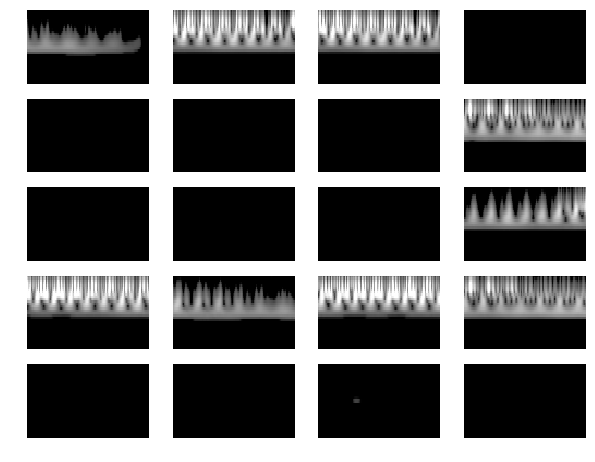

In [34]:
f(o3[0])

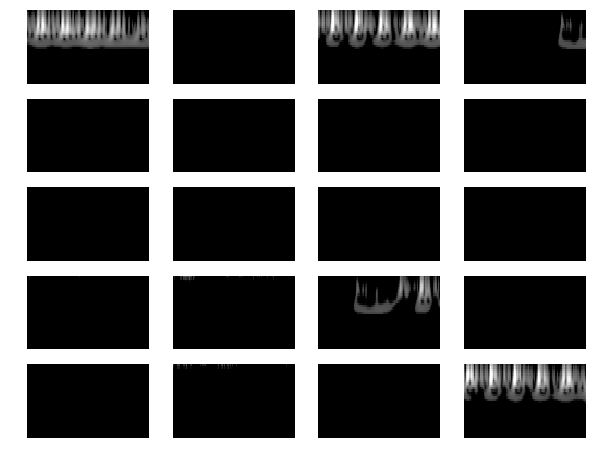

In [35]:
f(o3[1])